Robot Dynamic Model Identification
=======
---

# 1 - Praparing work

## Import libraries

In [95]:
# enable auto-reload modules
%load_ext autoreload
%autoreload 2
#interactive plotting in separate window
%matplotlib qt 
#%matplotlib inline

from sympy import init_printing
init_printing()
    
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [12, 8]

import numpy as np
import sympy
from robot_def import RobotDef
from kinematics import Geometry
from dynamics import Dynamics
from trajectory_optimization import TrajOptimizer
from trajectory_optimization import TrajPlotter
from utils import new_sym
from utils import save_data, load_data
import time

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Folder dir for saving and loading files

In [2]:
#model_name = 'psm_simple_coupled'
#model_name = 'psm_complete_coupled2'
model_name = 'psm_new_dh'

model_folder = 'data/' + model_name + '/model/'

---
# 2 - Robot modelling

## Robot geometry definition in following order

| Joint number | prev link | succ links | $a$ | $\alpha$ | $d$ | $\theta$ | link inertia | motor inertia | friction |
|--------------|-----------|------------|-----|----------|-----|----------|--------------|---------------|---------|

In [3]:
q0, q1, q2, q3, q4, q5, q6, q7, q8, q9, q10 = new_sym('q:11')
_pi = sympy.pi

dh = []
springs = []
friction_type = []
tendon_couplings = []

if (model_name == 'psm_simple_coupled'):
    beta = 0.2908
    beta2 = 0.0767 + beta
    delta = 0.6025
    
    q8 = 1.0186 * q5
    q9 = -0.8306 * q5 + 1.2178 * q6
    q10 = -0.8306 *q5 + 1.2178 * q7
    
    x = [None]*15
    x[0]  = ( 0,  -1,  [1, 13, 14],          0,           0,     0,                       0, False, False, False) # Base
    x[1]  = ( 1,   0,  [2],          0,  sympy.pi/2,     0,           q1+sympy.pi/2,  True, False,  True) # Yaw
    x[2]  = ( 2,   1,  [3],       0, -sympy.pi/2,     0,              sympy.pi/2, False, False, False) # -- Intermediate
    x[3]  = ( 3,   2,  [4, 7], -0.0296,       0,     0,    q2-beta - sympy.pi/2,  True, False,  True) # Pitch Back                                  )
    x[4]  = ( 4,   3,  [5],      0.150,           0,     0,     -q2+beta+sympy.pi/2,  True, False,  True)    # Pitch Bottom
    x[5]  = ( 5,   4,  [6],      0.516,           0,     0,                      q2,  True, False,  True)    # Pitch End
    x[6]  = ( 6,   5, [9],      0.043, -sympy.pi/2,-.28809+q3,          sympy.pi/2,  True, False,  True)    # Main Insertion
    x[7]  = ( 7,   3, [8],          0,           0,     0,         beta+sympy.pi/2, False, False, False) # Intermediate Counterweight
    x[8]  = ( 8,  7,   [],       -0.1, +sympy.pi/2, delta*q3,                    0,  True, False,  True) # Counterweight
    x[9] = (9,   6, [10],          0,           0,0.4162,          -sympy.pi/2+q4, False,  True,  True) # Tool Roll 
    x[10] = (10,  9, [11, 12],          0, sympy.pi/2,     0,          -sympy.pi/2 + q8, False,  True,  True) # Tool Pitch
    x[11] = (11,  10, [],  -0.0091 , sympy.pi/2,     0,          -sympy.pi/2 + q9, False,  False,  True) # Tool Yaw1
    x[12] = (12,  10, [],  -0.0091 , sympy.pi/2,     0,          -sympy.pi/2 + q10, False,  False,  True) # Tool Yaw2
    x[13] = (13,  0, [],  0 , 0,     0,          q6, False,  True,  False) # Tool Yaw1 inert
    x[14] = (14,  0, [],  0 , 0,     0,          q7, False,  True,  False) # Tool Yaw2 inert
    
    
    #x[12] = (12,  11, [],            0,           0,     0,                     -q7, False, False,  True) # Gripper1
    #x[13] = (13,  11, [],            0,           0,     0,                      q7, False,  True,  True) # Gripper2
    dh = x
    friction_type = ['Coulomb', 'viscous', 'offset']
    
    springs = [-q4]
    print(model_name)
elif (model_name == 'psm_complete_coupled2'):
    beta = 0.2908
    beta2 = 0.0767 + beta
    delta = 0.6025
    
    q8 = 1.0186 * q5
    q9 = -0.8306 * q5 + 1.2178 * q6
    q10 = -0.8306 *q5 + 1.2178 * q7
    
    x = [None]*19
    x[0]  = ( 0,  -1,  [1, 16, 17, 18],          0,           0,     0,                       0, False, False, False) # Base
    x[1]  = ( 1,   0,  [2],          0,  sympy.pi/2,     0,           q1+sympy.pi/2,  True, False,  True) # Yaw
    x[2]  = ( 2,   1,  [3, 4, 5],       0, -sympy.pi/2,     0,              sympy.pi/2, False, False, False) # -- Intermediate
    x[3]  = ( 3,   2,  [6, 10], -0.0296,       0,     0,    q2-beta - sympy.pi/2,  True, False,  True) # Pitch Back
    x[4]  = ( 4,   2,  [] ,     0.0664,           0,     0,    q2-beta - sympy.pi/2,  True, False,  True) # Pitch Front                                    )
    x[5]  = ( 5,   2,  [7],    -0.0296,           0,     0,   q2-beta2 - sympy.pi/2, False, False, False)    # Intermediate
    x[6]  = ( 6,   3,  [8],      0.150,           0,     0,     -q2+beta+sympy.pi/2,  True, False,  True)    # Pitch Bottom
    x[7]  = ( 7,   5,   [],     0.1842,           0,     0,    -q2+beta2+sympy.pi/2,  True, False,  True)    # Pitch Top
    x[8]  = ( 8,   6,  [9],      0.516,           0,     0,                      q2,  True, False,  True)    # Pitch End
    x[9]  = ( 9,   8, [12],      0.043, -sympy.pi/2,-.28809+q3,          sympy.pi/2,  True, False,  True)    # Main Insertion
    x[10] = (10,   3, [11],          0,           0,     0,         beta+sympy.pi/2, False, False, False) # Intermediate Counterweight
    x[11] = (11,  10,   [],       -0.1, +sympy.pi/2, delta*q3,                    0,  True, False,  True) # Counterweight
    
    x[12] = (12,   9, [13],          0,           0,0.4162,          -sympy.pi/2+q4, False,  True,  True) # Tool Roll 
    x[13] = (13,  12, [14, 15],          0, sympy.pi/2,     0,          -sympy.pi/2 + q8, False,  True,  True) # Tool Pitch
    x[14] = (14,  13, [],  -0.0091 -0.1, sympy.pi/2,     0,          -sympy.pi/2 + q9, False,  False,  True) # Tool Yaw1
    x[15] = (15,  13, [],  -0.0091 -0.1, sympy.pi/2,     0,          -sympy.pi/2 + q10, False,  False,  True) # Tool Yaw2
    x[16] = (16,  1, [],  0 , 0,     0,          q6, False,  True,  True) # Tool Yaw1 inert
    x[17] = (17,  1, [],  0 , 0,     0,          q7, False,  True,  True) # Tool Yaw2 inert
    x[18] = (18,  1, [],  0 , 0,     0,          q10-q9, False,  False,  True) # q6 q7 coupled friction
    
    dh = x
    friction_type = ['Coulomb', 'viscous', 'offset']
    springs = [-q4]
    print(model_name)
elif (model_name == 'psm_new_dh'):
    
    q8 = 1.0186 * q5
    q9 = -0.8306 * q5 + 1.2178 * q6
    q10 = -0.8306 *q5 + 1.2178 * q7
    
    l_2L1 = 96*0.001
    l_2L2 = 516*0.001
    l_2L3 = 40.09*0.001
    
    l_2H1 = 144.54*0.001
    l_2H2 = 38.08*0.001
    
    l_3 = 40.09*0.001
    
    l_RCC = 431.8*0.001
    l_tool = 416.2*0.001
    l_pitch2yaw = 9.1*0.001
    
    M_motor2dvrk_q = np.matrix([[1.0186, 0, 0], [-0.8306, 0.6089, 0.6089], [0, -1.2177, 1.2177]])
    M_model2dvrk_q = np.matrix([[1, 0, 0], [0, 0.5, 0.5], [0, -1, 1]])
    
    L_b = 0
    L_1 = 1
    L_20 = 2
    L_21 = 3
    L_22 = 4
    L_23 = 5
    L_24 = 6
    L_25 = 7
    L_30 = 8
    L_31 = 9
    L_4 = 10
    L_5 = 11
    L_6 = 12
    L_7 = 13
    M_6 = 14
    M_7 = 15
    F_67 = 16
    
    
    x = [None]*17
    x[0]  = (L_b,  -1,   [L_1, M_6, M_7, F_67], 0,           0,      0,              0,         False, False, False) # Base
    
    
    x[1]  = (L_1,  L_b,  [L_20, L_25],          0,           _pi/2,  0,              q1+_pi/2,  True,  False, True) # Yaw
    x[2]  = (L_20, L_1,  [L_21, L_31],          0,           -_pi/2, 0,              q2-_pi/2,  True,  False, True) # -- Intermediate
    x[3]  = (L_21, L_20, [L_22, L_23],          l_2L3,       0,      0,              _pi/2,     False, False, False) # Pitch Back
    x[4]  = (L_22, L_21, [L_24, L_25, L_30],    l_2H1,       0,      0,              -q2+_pi/2, True,  False, False) # Pitch Front                                    )
    x[5]  = (L_23, L_21, [],                    l_2H1+l_2H2, 0,      0,              -q2+_pi/2, True,  False, False)    # Intermediate
    x[6]  = (L_24, L_22, [L_30],                l_2L2,       0,      0,              q2,        True,  False, False)    # Pitch Bottom
    x[7]  = (L_25, L_22, [],                    l_2L1,       0,      0,              q2+_pi,    True,  False, False)    # Pitch Top
    x[8]  = (L_30, L_24, [L_4],                 l_3,         -_pi/2,  q3-l_RCC+l_2H1, 0,         True,  False, True)    # Pitch End
    x[9]  = (L_31, L_20, [],                    l_2L3,       -_pi/2, q3,             0,         True,  False, False)    # Main Insertion
    x[10] = (L_4,  L_30, [L_5],                 0,           0,      l_tool,         q4,        False, True,  True) # Intermediate Counterweight
    x[11] = (L_5,  L_4,  [L_6, L_7],            0,           _pi/2,  0,              q8+_pi/2,  False, True,  True) # Counterweight
    x[12] = (L_6,  L_5,  [],                    l_pitch2yaw, -_pi/2, 0,              q9+_pi/2,  False, False,  True) # Tool Roll 
    x[13] = (L_7,  L_5,  [],                    l_pitch2yaw, -_pi/2, 0,              q10+_pi/2,  False, False,  True) # Tool Pitch
    
    x[14] = (M_6,  L_b,  [],                    0,           0,      0,              q6,        False, True,  True) # Tool Yaw1 inert
    x[15] = (M_7,  L_b,  [],                    0,           0,      0,              q7,        False, True,  True) # Tool Yaw2 inert
    x[16] = (F_67, L_b,  [],                    0,           0,      0,              q10-q9,    False, False, True) # q6 q7 coupled friction
    
    dh = x
    friction_type = ['Coulomb', 'viscous', 'offset']
    springs = [-q4]
    print(model_name)
else:
    raise Exception("No robot name matches " + name)
print(friction_type)
robot_def = RobotDef(dh,
                     springs=springs,
                     tendon_couplings=tendon_couplings,
                     dh_convention='mdh',
                     friction_type=friction_type)

psm_new_dh
['Coulomb', 'viscous', 'offset']


In [4]:
M_motor2dvrk_q = np.matrix([[1.0186, 0, 0], [-0.8306, 0.6089, 0.6089], [0, -1.2177, 1.2177]])
M_model2dvrk_q = np.matrix([[1, 0, 0], [0, 0.5, 0.5], [0, -1, 1]])
M_motor2model_q = np.linalg.inv(M_model2dvrk_q)*M_motor2dvrk_q
M_motor2model_q[np.abs(M_motor2model_q) < 0.0001] = 0
M_motor2model_q

matrix([[ 1.0186 ,  0.     ,  0.     ],
        [-0.8306 ,  1.21775,  0.     ],
        [-0.8306 ,  0.     ,  1.21775]])

In [5]:
robot_def.coordinates_joint_type

['R', 'R', 'P', 'R', 'R', 'R', 'R']

In [6]:
robot_def.bary_params

## Create kinematics chain

In [7]:
%time geom = Geometry(robot_def)

Frame: 0
Frame: 1
Frame: 2
Frame: 3
Frame: 4
Frame: 5
Frame: 6
Frame: 7
Frame: 8
Frame: 9
Frame: 10
Frame: 11
Frame: 12
Frame: 13
Frame: 14
Frame: 15
Frame: 16
CPU times: user 11min 23s, sys: 2.33 s, total: 11min 25s
Wall time: 11min 23s


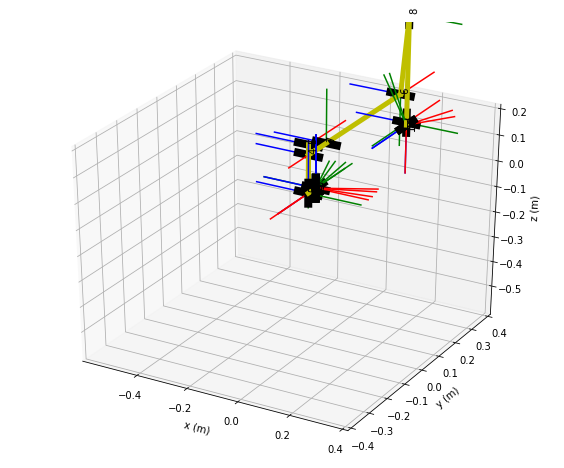

In [12]:
angle = [0, 0.0, 0, 0, 0, 0.3, 0.4]
geom.draw_geom(angle)

## Create dynamics

In [14]:
dyn = Dynamics(robot_def, geom)

Calculating Lagrangian...
Calculating the link kinetic energy of 1/16
Calculating the link kinetic energy of 2/16
Calculating the link kinetic energy of 4/16
Calculating the link kinetic energy of 5/16
Calculating the link kinetic energy of 6/16
Calculating the link kinetic energy of 7/16
Calculating the link kinetic energy of 8/16
Calculating the link kinetic energy of 9/16
Calculating joint torques...
tau of q1
tau of q2
tau of q3
tau of q4
tau of q5
tau of q6
tau of q7
Adding frictions and springs...
Add tendon coupling torque and motor inertia...
Calculating gregressor...
('input_vars', (q1, q2, q3, q4, q5, q6, q7, dq1, dq2, dq3, dq4, dq5, dq6, dq7, ddq1, ddq2, ddq3, ddq4, ddq5, ddq6, ddq7))
Calculating M, C and G...
Calculating base parameter...
base parameter number: 49
Creating H_b function...
Finished creating robot dynamics


In [15]:
sympy.Matrix(dyn.base_param)

⎡                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                   

In [16]:
from data import RobotModel

# Data to be saved
robot_model = RobotModel(dyn)

# Save
save_data(model_folder, model_name, robot_model)
print('Saved {} parameters'.format(len(robot_model.base_param)))

Saved 49 parameters


---
# 3 - Excitation trajectory optimization

In [9]:
model_name = 'psm_simple_coupled'
#model_name = 'psm_complete_coupled'

Load Data

In [10]:
from utils import load_data
model_folder = 'data/' + model_name + '/model/'
robot_model = load_data(model_folder, model_name)

## Create trajectory optimizer object, with H matrix, foourier order, base frequency, joint constraints and cartisian constraints as input

In [11]:
trajectory_name = 'five'
#trajectory_name = 'two'
# trajectory_name = 'two_normalized'

In [19]:
from numpy import deg2rad

optimal_trajectory_folder = 'data/optimal_trajectory/'
trajectory_folder = 'data/' + model_name +'/optimal_trajectory/'

base_freq = 0.18
fourier_order = 6

joint_constraints = []
cartesian_constraints = []

if model_name == 'mtm' or model_name == 'mtm_spring'\
    or model_name == 'mtm_2spring' or model_name == 'mtm_2spring_tendon':
    joint_constraints = [(q1, deg2rad(-57), deg2rad(29), deg2rad(-160), deg2rad(160)),
                         (q2, deg2rad(-10), deg2rad(60), deg2rad(-180), deg2rad(180)),
                         (q3, deg2rad(-30), deg2rad(30), deg2rad(-180), deg2rad(180)),
                         (q4, deg2rad(-40), deg2rad(195), -6*np.pi, 6*np.pi),
                         (q5, deg2rad(-87), deg2rad(180), -6*np.pi, 6*np.pi),
                         (q6, deg2rad(-40), deg2rad(38), -6*np.pi, 6*np.pi),
                         (q7, deg2rad(-460), deg2rad(450), -10*np.pi, 10*np.pi),
                         (q8, deg2rad(-9), deg2rad(39), deg2rad(-150), deg2rad(150))]

#     cartesian_constraints = [(3,'max',1,0.4,1),
#                              (3,'min',-1,-1,-1)]
elif model_name == 'psm_simple_coupled':
    q_dvrk7 = (12177*q7)/10000 - (12177*q6)/10000
    q_mod6 = (4871*q6)/4000 - (4153*q5)/5000
    q_mod7 = - (4153*q5)/5000 + (4871*q7)/4000
    
    joint_constraints = [(q1, -1.45, 1.45, -2, 2),
                         (q2, -0.75, 0.8, -2, 2),
                         (q3,0.05,0.235,-0.4,0.4),
                         (q4,-1.5,1.5,-2,2),
                         (q5,-1.5,1.5,-3,3), 
                         (q_dvrk7, 0.15, np.pi,-3,3),
                         (q_mod6, -1.5, 3,-3,3),
                          (q_mod7, -3, 1.5,-3,3)]
else:
    raise Exception("No robot name matches " + model_name)
    
traj_optimizer = TrajOptimizer(robot_model, fourier_order, base_freq,
                               joint_constraints=joint_constraints,
                               cartesian_constraints = cartesian_constraints)
                                                                                                 
                                                                                                                     
traj_optimizer.optimize()


joint constraint number: 8
cartesian constraint number: 0
constraint number: 32
frames_constrained: []
cond: 210.985740882
cond: 210.985747127
cond: 210.98573398
cond: 210.985744172
cond: 210.985758163
cond: 210.985752104
cond: 210.985749206
cond: 210.985741141
cond: 210.985760944
cond: 210.9857505
cond: 210.985751642
cond: 210.98574567
cond: 210.985737237
cond: 210.985731538
cond: 210.985698421
cond: 210.985733269
cond: 210.98573046
cond: 210.985728668
cond: 210.985743298
cond: 210.985754696
cond: 210.985752709
cond: 210.985783657
cond: 210.985769139
cond: 210.985761763
cond: 210.985760937
cond: 210.985757532
cond: 210.98574957
cond: 210.985701811
cond: 210.985720757
cond: 210.985746151
cond: 210.985748008
cond: 210.985749768
cond: 210.985748147
cond: 210.985746473
cond: 210.985780629
cond: 210.985753095
cond: 210.985750562
cond: 210.985754212
cond: 210.985751377
cond: 210.985749971
cond: 210.985740882
cond: 210.985740882
cond: 210.985740882
cond: 210.985740882
cond: 210.985740882
con

cond: 500.508662043
cond: 500.5086607
cond: 500.508657151
cond: 500.508657151
cond: 500.508657151
cond: 500.508657151
cond: 500.508657151
cond: 500.508657151
cond: 500.508657151
cond: 500.508657151
cond: 500.508657151
cond: 500.508657151
cond: 500.508657151
cond: 500.508657151
cond: 500.508657151
cond: 500.508657151
cond: 500.508657151
cond: 500.508657151
cond: 500.508657151
cond: 500.508657151
cond: 500.508657151
cond: 500.508657151
cond: 500.508657151
cond: 500.508657151
cond: 500.508657151
cond: 500.508657151
cond: 500.508657151
cond: 500.508657151
cond: 500.508657151
cond: 500.508657151
cond: 500.508657151
cond: 500.508657151
cond: 500.508657151
cond: 500.508657151
cond: 500.508657151
cond: 500.508657151
cond: 500.508657151
cond: 500.508657151
cond: 500.508657151
cond: 500.508657151
cond: 500.508657151
cond: 500.508657151
cond: 500.508657151
cond: 500.508657151
cond: 500.508657151
cond: 500.508657151
cond: 500.508657151
cond: 500.508657151
cond: 500.508657151
cond: 500.508657151
co

cond: 417.143031067
cond: 417.143031067
cond: 417.143031067
cond: 417.143031067
cond: 417.143031067
cond: 417.143031067
cond: 417.143031067
cond: 417.143031067
cond: 417.143031067
cond: 417.143031067
cond: 417.143031067
cond: 417.143031067
cond: 417.143031067
cond: 417.143031067
cond: 417.143031067
cond: 417.143031067
cond: 623.225061485
cond: 446.692001547
cond: 412.006101441
cond: 412.005934632
cond: 412.006105596
cond: 412.006200019
cond: 412.005923132
cond: 412.006126218
cond: 412.006031358
cond: 412.006129499
cond: 412.005786622
cond: 412.00613393
cond: 412.006141264
cond: 412.00616085
cond: 412.006183117
cond: 412.006249445
cond: 412.007314403
cond: 412.006007328
cond: 412.005987312
cond: 412.006031525
cond: 412.005994747
cond: 412.006083121
cond: 412.00599551
cond: 412.005094346
cond: 412.006026198
cond: 412.006306577
cond: 412.006246604
cond: 412.006228539
cond: 412.006062546
cond: 412.006094911
cond: 412.006244901
cond: 412.006100122
cond: 412.006166217
cond: 412.006116012
con

cond: 384.823932322
cond: 384.824003301
cond: 384.824074787
cond: 384.824099439
cond: 384.824189186
cond: 384.824105111
cond: 384.823346173
cond: 384.824206158
cond: 384.824403153
cond: 384.824333453
cond: 384.824308367
cond: 384.824143221
cond: 384.824194858
cond: 384.824247182
cond: 384.824193867
cond: 384.824220665
cond: 384.824193081
cond: 384.824211277
cond: 384.82418792
cond: 384.824197943
cond: 384.824183243
cond: 384.824196693
cond: 384.824181522
cond: 384.824190461
cond: 384.824203425
cond: 384.824196283
cond: 384.824196283
cond: 384.824196283
cond: 384.824196283
cond: 384.824196283
cond: 384.824196283
cond: 384.824196283
cond: 384.824196283
cond: 384.824196283
cond: 384.824196283
cond: 384.824196283
cond: 384.824196283
cond: 384.824196283
cond: 384.824196283
cond: 384.824196283
cond: 384.824196283
cond: 384.824196283
cond: 384.824196283
cond: 384.824196283
cond: 384.824196283
cond: 384.824196283
cond: 384.824196283
cond: 384.824196283
cond: 384.824196283
cond: 384.824196283
c

cond: 365.30433919
cond: 365.30433919
cond: 365.30433919
cond: 365.30433919
cond: 365.30433919
cond: 365.30433919
cond: 365.30433919
cond: 365.30433919
cond: 365.30433919
cond: 365.30433919
cond: 365.30433919
cond: 365.30433919
cond: 365.30433919
cond: 365.30433919
cond: 365.30433919
cond: 365.30433919
cond: 365.30433919
cond: 365.30433919
cond: 365.30433919
cond: 365.30433919
cond: 365.30433919
cond: 365.30433919
cond: 365.30433919
cond: 365.30433919
cond: 365.30433919
cond: 365.30433919
cond: 365.30433919
cond: 365.30433919
cond: 365.30433919
cond: 365.30433919
cond: 365.30433919
cond: 365.30433919
cond: 365.30433919
cond: 365.30433919
cond: 365.30433919
cond: 365.30433919
cond: 365.30433919
cond: 365.30433919
cond: 365.30433919
cond: 365.30433919
cond: 365.30433919
cond: 365.30433919
cond: 208.404367598
cond: 296.028246112
cond: 324.65238191
cond: 324.652400468
cond: 324.652543792
cond: 324.652266395
cond: 324.652409639
cond: 324.652367602
cond: 324.652375874
cond: 324.652414733
con

cond: 325.455680308
cond: 325.455687838
cond: 325.455537182
cond: 325.455558142
cond: 325.45572273
cond: 325.455686877
cond: 325.455682881
cond: 325.456538728
cond: 325.455556295
cond: 325.455541591
cond: 325.455573808
cond: 325.455569352
cond: 325.455628385
cond: 325.45556024
cond: 325.454818598
cond: 325.455619972
cond: 325.455820491
cond: 325.455782676
cond: 325.455745048
cond: 325.455592102
cond: 325.455614759
cond: 325.455672332
cond: 325.455623197
cond: 325.455654161
cond: 325.455632431
cond: 325.455616783
cond: 325.455595203
cond: 325.455593195
cond: 325.45560225
cond: 325.455652975
cond: 325.455637225
cond: 325.455648916
cond: 325.45560599
cond: 325.455628797
cond: 325.455628797
cond: 325.455628797
cond: 325.455628797
cond: 325.455628797
cond: 325.455628797
cond: 325.455628797
cond: 325.455628797
cond: 325.455628797
cond: 325.455628797
cond: 325.455628797
cond: 325.455628797
cond: 325.455628797
cond: 325.455628797
cond: 325.455628797
cond: 325.455628797
cond: 325.455628797
cond

cond: 314.477794009
cond: 314.477794009
cond: 314.477794009
cond: 314.477794009
cond: 314.477794009
cond: 314.477794009
cond: 314.477794009
cond: 314.477794009
cond: 314.477794009
cond: 314.477794009
cond: 314.477794009
cond: 314.477794009
cond: 314.477794009
cond: 314.477794009
cond: 314.477794009
cond: 314.477794009
cond: 314.477794009
cond: 314.477794009
cond: 314.477794009
cond: 314.477794009
cond: 314.477794009
cond: 314.477794009
cond: 314.477794009
cond: 314.477794009
cond: 314.477794009
cond: 314.477794009
cond: 314.477794009
cond: 314.477794009
cond: 314.477794009
cond: 314.477794009
cond: 314.477794009
cond: 314.477794009
cond: 314.477794009
cond: 314.477794009
cond: 314.477794009
cond: 314.477794009
cond: 314.477794009
cond: 314.477794009
cond: 314.477794009
cond: 314.477794009
cond: 314.477794009
cond: 314.477794009
cond: 314.477794009
cond: 314.477794009
cond: 314.477794009
cond: 314.477794009
cond: 314.477794009
cond: 309.483606216
cond: 307.496887761
cond: 307.496952854


cond: 305.703145421
cond: 305.703145421
cond: 305.703145421
cond: 305.703145421
cond: 305.703145421
cond: 305.703145421
cond: 305.703145421
cond: 330.268473858
cond: 306.642513328
cond: 306.003151437
cond: 305.805063064
cond: 305.804992593
cond: 305.805075374
cond: 305.80515419
cond: 305.805119332
cond: 305.805016141
cond: 305.804965749
cond: 305.805110449
cond: 305.804970768
cond: 305.804979537
cond: 305.805106275
cond: 305.805163066
cond: 305.805085365
cond: 305.805115954
cond: 305.805962104
cond: 305.805050417
cond: 305.805009085
cond: 305.80501285
cond: 305.804992319
cond: 305.805040954
cond: 305.804987773
cond: 305.804285953
cond: 305.805048584
cond: 305.805248118
cond: 305.805208276
cond: 305.805167106
cond: 305.805023763
cond: 305.805045998
cond: 305.805107976
cond: 305.805058116
cond: 305.80508644
cond: 305.80506677
cond: 305.805051457
cond: 305.80503983
cond: 305.805028492
cond: 305.805037155
cond: 305.805085149
cond: 305.805067092
cond: 305.805065834
cond: 305.805037552
cond:

cond: 300.35528086
cond: 300.355284403
cond: 300.355273568
cond: 300.355288384
cond: 300.35527671
cond: 300.355298237
cond: 300.355291078
cond: 300.355297276
cond: 300.355276751
cond: 300.355287107
cond: 300.355287107
cond: 300.355287107
cond: 300.355287107
cond: 300.355287107
cond: 300.355287107
cond: 300.355287107
cond: 300.355287107
cond: 300.355287107
cond: 300.355287107
cond: 300.355287107
cond: 300.355287107
cond: 300.355287107
cond: 300.355287107
cond: 300.355287107
cond: 300.355287107
cond: 300.355287107
cond: 300.355287107
cond: 300.355287107
cond: 300.355287107
cond: 300.355287107
cond: 300.355287107
cond: 300.355287107
cond: 300.355287107
cond: 300.355287107
cond: 300.355287107
cond: 300.355287107
cond: 300.355287107
cond: 300.355287107
cond: 300.355287107
cond: 300.355287107
cond: 300.355287107
cond: 300.355287107
cond: 300.355287107
cond: 300.355287107
cond: 300.355287107
cond: 300.355287107
cond: 300.355287107
cond: 300.355287107
cond: 300.355287107
cond: 300.355287107
co

cond: 299.313038453
cond: 299.313038453
cond: 299.313038453
cond: 299.313038453
cond: 299.313038453
cond: 299.313038453
cond: 299.313038453
cond: 299.313038453
cond: 299.313038453
cond: 299.313038453
cond: 299.313038453
cond: 299.313038453
cond: 299.313038453
cond: 299.313038453
cond: 299.313038453
cond: 299.313038453
cond: 299.313038453
cond: 299.313038453
cond: 299.313038453
cond: 299.313038453
cond: 299.313038453
cond: 299.313038453
cond: 299.313038453
cond: 299.313038453
cond: 299.313038453
cond: 299.313038453
cond: 299.313038453
cond: 299.313038453
cond: 299.313038453
cond: 299.313038453
cond: 549.429072255
cond: 374.883914726
cond: 303.633441599
cond: 299.204460655
cond: 299.204455191
cond: 299.204506202
cond: 299.204460174
cond: 299.204401495
cond: 299.204383993
cond: 299.20440076
cond: 299.204479192
cond: 299.204414059
cond: 299.204471923
cond: 299.204501728
cond: 299.204489132
cond: 299.204454074
cond: 299.204533842
cond: 299.205328922
cond: 299.204443147
cond: 299.204420516
c

cond: 299.095918171
cond: 299.095903658
cond: 299.095969689
cond: 299.095919127
cond: 299.095860421
cond: 299.09584131
cond: 299.09585681
cond: 299.095936908
cond: 299.095868922
cond: 299.095929659
cond: 299.09596009
cond: 299.095946035
cond: 299.095909257
cond: 299.095989851
cond: 299.096787625
cond: 299.095899369
cond: 299.09587689
cond: 299.095875413
cond: 299.095855512
cond: 299.095882984
cond: 299.095843311
cond: 299.095140278
cond: 299.095873194
cond: 299.096065848
cond: 299.096038276
cond: 299.096016995
cond: 299.095880246
cond: 299.095900837
cond: 299.095941469
cond: 299.095910052
cond: 299.095930228
cond: 299.095914317
cond: 299.095909085
cond: 299.095903706
cond: 299.095905011
cond: 299.095904837
cond: 299.095934718
cond: 299.095921514
cond: 299.095932598
cond: 299.095900398
cond: 299.095918171
cond: 299.095918171
cond: 299.095918171
cond: 299.095918171
cond: 299.095918171
cond: 299.095918171
cond: 299.095918171
cond: 299.095918171
cond: 299.095918171
cond: 299.095918171
cond

cond: 118.936524858
cond: 118.936526109
cond: 118.936525643
cond: 118.936526185
cond: 118.936526185
cond: 118.936526185
cond: 118.936526185
cond: 118.936526185
cond: 118.936526185
cond: 118.936526185
cond: 118.936526185
cond: 118.936526185
cond: 118.936526185
cond: 118.936526185
cond: 118.936526185
cond: 118.936526185
cond: 118.936526185
cond: 118.936526186
cond: 118.936526187
cond: 118.936526186
cond: 118.936526186
cond: 118.936526187
cond: 118.936526185
cond: 118.936526183
cond: 118.936526189
cond: 118.936526184
cond: 118.936526185
cond: 118.936526187
cond: 118.936526183
cond: 118.936526185
cond: 118.936526185
cond: 118.936526186
cond: 118.936526185
cond: 118.936526185
cond: 118.936526185
cond: 118.936526185
cond: 118.936526185
cond: 118.936526185
cond: 118.936526185
cond: 118.936526184
cond: 118.936526184
cond: 118.936526185
cond: 118.936526185
cond: 118.936526185
cond: 118.936526185
cond: 118.936526185
cond: 118.936526185
cond: 118.936526185
cond: 118.936526185
cond: 118.936526185


In [20]:
reg_norm_mat = traj_optimizer.calc_normalize_mat()

## Plot optimal excitation trajectory

In [21]:
traj_optimizer.calc_frame_traj()

In [25]:
traj_plotter = TrajPlotter(traj_optimizer.fourier_traj,traj_optimizer.frame_traj,
                           traj_optimizer.const_frame_ind, robot_model.coordinates)
traj_plotter.plot_desired_traj(traj_optimizer.x_result)

traj_plotter.plot_frame_traj(True)

## Save trajectory for later use

In [23]:
dof_order_bf_x_norm = (traj_optimizer.fourier_traj.dof, fourier_order,
                       base_freq, traj_optimizer.x_result, reg_norm_mat)
save_data(trajectory_folder, trajectory_name, dof_order_bf_x_norm)

freq = 500
tf = 35 # including 5 seconds' prestable time
traj_optimizer.make_traj_csv(trajectory_folder, trajectory_name, freq, tf)

In [24]:
from IPython.display import HTML, display
import tabulate

table = []
table.append(["joint", 'qo'] +
             ["a"+str(i+1) for i in range(fourier_order)] +
             ["b"+str(i+1) for i in range(fourier_order)])
for i in range(traj_optimizer.fourier_traj.dof):
    line = []
    line.append(robot_model.coordinates[i])
    line += np.round(traj_optimizer.x_result[i*(1 + fourier_order*2): (i+1)*(1 + fourier_order*2)], 4).tolist()
    table.append(line)

display(HTML(tabulate.tabulate(table, tablefmt='html')))

joint,qo,a1,a2,a3,a4,a5,a6,b1,b2,b3,b4,b5,b6
q1,-0.2117,-0.2284,2.3638,0.0241,3.8529,0.0647,-0.3299,-0.0269,-1.104,-0.1744,1.3729,0.21,1.3776
q2,-0.0284,-0.1867,0.0905,-0.1835,0.0563,-0.2268,0.7106,0.6018,-0.1312,-0.6209,0.0858,-0.303,0.5218
q3,0.1524,0.1,0.2504,0.3023,0.1114,-0.1436,0.0599,0.1024,-0.0204,-0.2083,-0.3015,-0.3454,0.0163
q4,0.301,-0.6228,-0.2123,0.6638,0.1955,0.3863,-0.1471,0.0784,0.6866,-0.3607,0.3601,0.1482,0.5614
q5,0.0998,-0.4981,0.656,0.3323,0.4983,-0.2354,0.3538,0.546,0.4261,1.6326,0.2325,-1.0421,0.9154
q6,-0.2705,0.6914,0.1312,0.3671,0.4374,0.2859,0.7322,0.317,1.1456,1.5541,1.1735,-0.5477,0.2054
q7,0.6206,0.22,0.3858,0.7048,0.2758,0.2773,0.6134,0.2441,0.8919,1.3162,0.3569,0.3831,0.1226


---
# Data processing

## Load data

In [46]:
from identification import load_trajectory_data, diff_and_filt_data, plot_trajectory_data, plot_meas_pred_tau, gen_regressor

### Load robot model

In [47]:
# Names as Arguments

#model_name = 'psm_no_off_minert'
# model_name = 'psm_complete_coupled2'
model_name = 'psm_new_dh'

training_trajectory_name = 'four'


model_folder = 'data/' + model_name + '/model/'
robot_model = load_data(model_folder,model_name)


trajectory_folder = 'data/' + model_name +'/optimal_trajectory/'
dof, fourier_order, base_freq, traj_optimizer_result, reg_norm_mat = load_data(trajectory_folder,
                                                                          training_trajectory_name)
#dof, fourier_order, base_freq, traj_optimizer_result = load_data(trajectory_folder,training_trajectory_name)
     
print("dof: {}".format(dof))
print("Fourier order: {}".format(fourier_order))
print("Base frequency: {}".format(base_freq))

dof: 7
Fourier order: 6
Base frequency: 0.2


### Load traning data set

In [48]:
# training_trajectory_name = 'one'

results_folder = 'data/' + model_name +'/measured_trajectory/'
training_results_data_file = results_folder + training_trajectory_name + '_results.csv'

trajectory_sampling_rate = 500
t_train, q_raw_train, dq_raw_train, tau_raw_train = load_trajectory_data(training_results_data_file,
                                                                   trajectory_sampling_rate)

(<type 'numpy.ndarray'>, (14999, 21))


### Load test data set

In [102]:
test_trajectory_name = 'two'

results_folder = 'data/' + model_name +'/measured_trajectory/'
test_results_data_file = results_folder + test_trajectory_name + '_results.csv'

trajectory_sampling_rate = 500
t_test, q_raw_test, dq_raw_test, tau_raw_test = load_trajectory_data(test_results_data_file,
                                                                   trajectory_sampling_rate)

(<type 'numpy.ndarray'>, (14999, 21))


## Calculate filter cut-off frequency

In [50]:
# times of the highest frequency in the Fourier series
#fc_mult = 4.0

#fc_mult = [1.3] #(good)
fc_mult = [5, 5, 5, 3, 4, 4, 4]

#fc_mult = 4
print(base_freq)
fc = np.array(fc_mult)*base_freq* fourier_order 

print(fc)


0.2
[6.  6.  6.  3.6 4.8 4.8 4.8]


## Differentiation and filtering

### Traning data

[0.07539822 0.07539822 0.07539822 0.04523893 0.06031858 0.06031858
 0.06031858]
q_raw shape: (14999, 7)
plot shape: 470


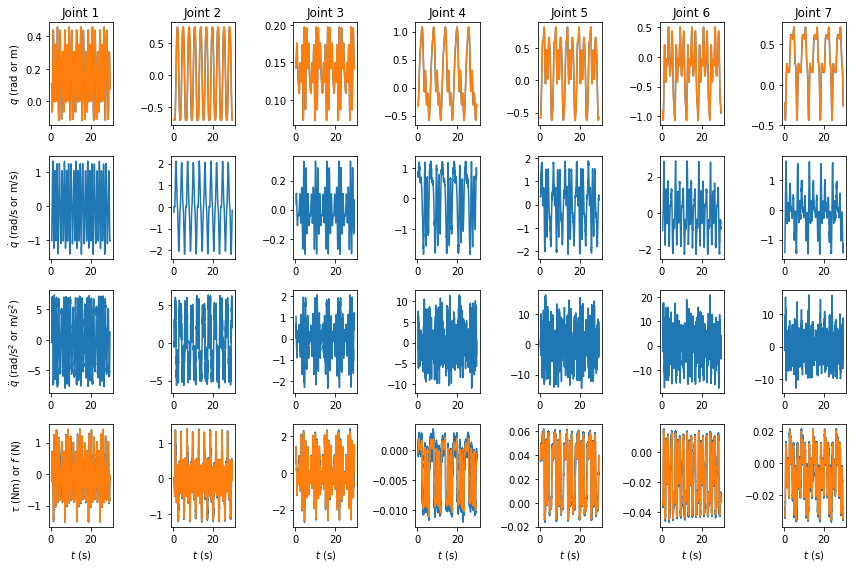

In [51]:
t_cut_train, q_f_train, dq_f_train, ddq_f_train, tau_f_train, q_raw_cut_train, tau_raw_cut_train =\
    diff_and_filt_data(dof, 1.0/trajectory_sampling_rate,
                       t_train, q_raw_train, dq_raw_train, tau_raw_train, fc, fc, fc, fc)
plot_trajectory_data(t_cut_train, q_raw_cut_train, q_f_train, dq_f_train, ddq_f_train,
                     tau_raw_cut_train, tau_f_train)

### Test data

[0.07539822 0.07539822 0.07539822 0.04523893 0.06031858 0.06031858
 0.06031858]
q_raw shape: (14999, 7)
plot shape: 470


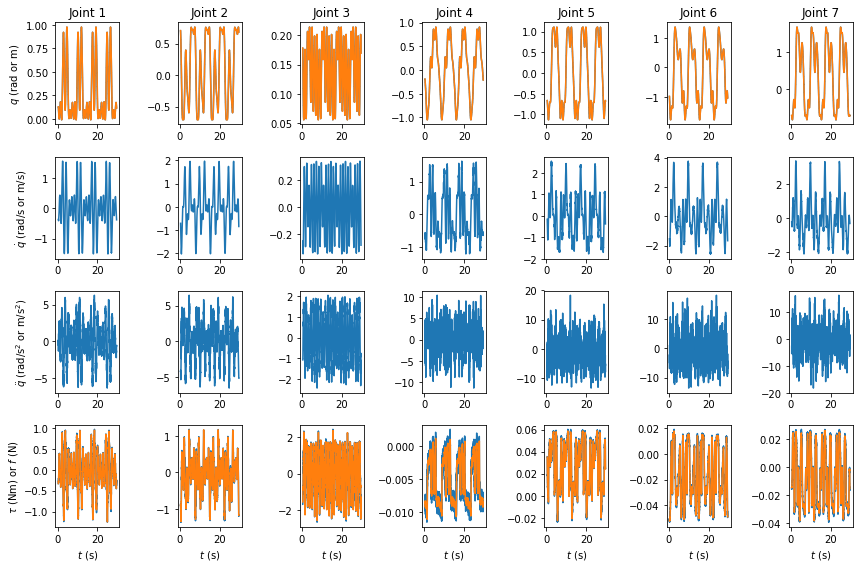

In [52]:
t_cut_test, q_f_test, dq_f_test, ddq_f_test,tau_f_test, q_raw_cut_test, tau_raw_cut_test =\
    diff_and_filt_data(dof, 1.0/trajectory_sampling_rate,
                       t_test, q_raw_test, dq_raw_test, tau_raw_test, fc, fc, fc, fc)
plot_trajectory_data(t_cut_test, q_raw_cut_test, q_f_test, dq_f_test, ddq_f_test,
                     tau_raw_cut_test, tau_f_test)

---
# Regression

## Ordinary Least Square (OLS)

### Generate regressor matrix for base parameters

In [53]:
base_param_num = robot_model.base_num
H_b_func = robot_model.H_b_func
W_b_train, tau_s_train = gen_regressor(base_param_num, H_b_func, q_f_train,
                                       dq_f_train, ddq_f_train, tau_f_train)

In [54]:
W_b_train.shape, tau_s_train.shape
#print np.linalg.cond(W_b_train)

In [55]:
xb_ols = np.linalg.lstsq(W_b_train, tau_s_train)[0]

/home/yan/anaconda2/envs/dynamics/lib/python2.7/site-packages/ipykernel_launcher.py:1: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  """Entry point for launching an IPython kernel.


In [56]:
#sympy.Matrix.hstack(sympy.Matrix(robot_model.base_param), sympy.Matrix(xb_ols))

from IPython.display import HTML, display
import tabulate

table = [["Base Parameter", "Value"]]

for i in range(robot_model.base_num):
    param_str = str(sympy.Matrix(robot_model.base_param)[i])
    max_disp_len = 50
    line = [param_str if len(param_str) <= max_disp_len 
            else param_str[:max_disp_len] + '...', xb_ols[i]]
    #['%.7s ...'%b if len(str(b)) > 7 else str(b)
    table.append(line)

display(HTML(tabulate.tabulate(table, tablefmt='html')))

Base Parameter,Value
1.0*m8,0.33265315623270153
1.0*m9,0.34911885993910197
0.5*l2y - 0.5*l6y + 0.5*l7y + 1.0*l9z + 0.07227*m4...,-0.13076719228465686
-0.5*l2x + 0.5*l6x - 0.5*l7x + 1.0*l8x - 0.020045*...,0.02234436609539208
-0.5*l2y + 0.5*l6y - 0.5*l7y + 1.0*l8z - 0.07227*m...,0.07627828951781554
0.5*l2x - 0.5*l6x + 0.5*l7x + 1.0*l9x + 0.020045*m...,-0.02703089170376261
-0.5*l1y - 0.5*l2z - 0.5*l4z - 0.5*l5z - 0.5*l6z -...,0.02285578740600381
-0.5*l1y - 0.5*l2z - 0.5*l4z - 0.5*l5z - 0.5*l6z -...,0.019097126835601372
1.0*l5y,-0.6487914241452868
1.0*Fv16,0.0020286257534983107


## Compare measured torque and predicted torque on the training set

### Generate predicted torque

In [57]:
tau_p_train = np.zeros(tau_f_train.shape)
tau_ps_train = W_b_train.dot(xb_ols)
for i in range(dof):
    tau_p_train[:, i] = tau_ps_train[i::dof]
    

### Evaluate regression

In [58]:
var_regression_error_ols = np.linalg.norm(tau_ps_train - tau_s_train) / \
                        (tau_ps_train.size - base_param_num)
print("variance of regression error using OLS:")
print(var_regression_error_ols)

std_dev_xb_ols = np.sqrt(np.diag(var_regression_error_ols *
                                 np.linalg.inv(W_b_train.transpose().dot(W_b_train))))
print("standard deviation of xb using OLS:")
print(std_dev_xb_ols)

pct_std_dev_xb_ols = std_dev_xb_ols / np.abs(xb_ols)
print("percentage of standard deviation of xb using OLS: ")
print(pct_std_dev_xb_ols)

variance of regression error using OLS:
0.0002541516188401579
standard deviation of xb using OLS:
[2.09126332e-04 2.22724558e-04 7.80863806e-05 6.46479733e-05
 6.22130832e-05 7.16700883e-05 5.68983490e-04 5.73737051e-04
 5.82638372e-02 1.62758059e-04 2.79198516e-04 2.04535622e-04
 2.06209812e-04 4.35888083e-05 2.40696798e-04 2.34515403e-03
 2.85072396e-04 3.53721105e-05 1.82866139e-04 3.54388312e-05
 2.45991273e-05 1.72136162e-03 3.55709382e-04 2.07611252e-05
 1.12078815e-04 3.43002317e-04 1.15019757e-04 2.37342131e-04
 1.75714481e-03 1.56294020e-04 3.35662383e-04 5.90974252e-03
 2.54500463e-04 1.47023768e-04 1.64015543e-04 1.03975775e-03
 1.11837299e-02 2.82665327e-03 1.53433855e-04 2.06982073e-04
 1.81140784e-04 2.96497410e-04 2.95176969e-04 1.98469788e-04
 2.46683428e-04 2.45546575e-04 2.24661303e-04 2.43072706e-04
 6.09110985e-02]
percentage of standard deviation of xb using OLS: 
[6.28661799e-04 6.37961976e-04 5.97140454e-04 2.89325609e-03
 8.15606689e-04 2.65141413e-03 2.48945039

### Plot measured torque and predicted torque

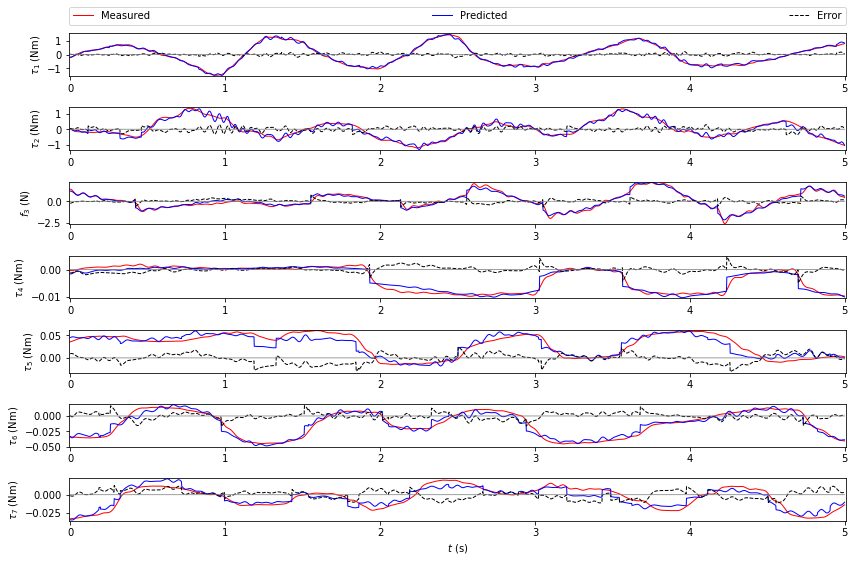

In [59]:
plot_data_num = int(1 / base_freq * trajectory_sampling_rate)
plot_meas_pred_tau(t_cut_train[:plot_data_num], tau_f_train[:plot_data_num, :],
                   tau_p_train[:plot_data_num, :],
                   robot_model.coordinates_joint_type,
                   robot_model.coordinates)

## Compare measured torque and predicted torque on the test set

In [60]:
W_b_test, tau_s_test = gen_regressor(base_param_num, H_b_func, q_f_test,
                                       dq_f_test, ddq_f_test, tau_f_test)

tau_p_test = np.zeros(tau_f_test.shape)
tau_ps_test = W_b_test.dot(xb_ols)
for i in range(dof):
    tau_p_test[:, i] = tau_ps_test[i::dof]

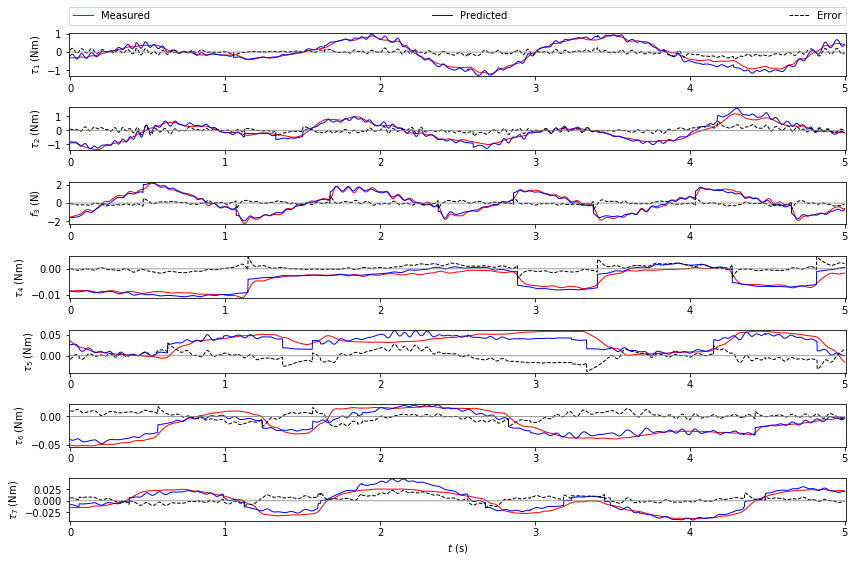

In [61]:
plot_data_num = int(1 / base_freq * trajectory_sampling_rate)
plot_meas_pred_tau(t_cut_test[:plot_data_num], tau_f_test[:plot_data_num, :],
                   tau_p_test[:plot_data_num, :],
                   robot_model.coordinates_joint_type,
                   robot_model.coordinates)

In [62]:
np.linalg.norm(tau_f_test[:plot_data_num, :] - tau_p_test[:plot_data_num, :], axis=0)\
    / np.linalg.norm(tau_f_test[:plot_data_num, :], axis=0)

array([0.2045042 , 0.25303996, 0.15977677, 0.20544639, 0.30251404,
       0.26174058, 0.35916099])

## Weighted Least Square (WLS)

### Training data set

In [63]:
# weight = np.sqrt(np.linalg.norm(tau_f - tau_p, axis=0)/(tau_f.shape[0] - base_param_num))
weight = np.max(tau_f_train, axis=0) - np.min(tau_f_train, axis=0)
weight

array([2.92383044, 2.60356677, 4.86492917, 0.01327816, 0.07517114,
       0.05958492, 0.0563712 ])

In [64]:
W_b_train.shape, tau_s_train.shape

In [65]:
# repeat the weight to generate a large vecoter for all the data
weights = 1.0/np.tile(weight, W_b_train.shape[0]/weight.shape[0])

In [66]:
W_b_wls_train = np.multiply(W_b_train, np.asmatrix(weights).transpose())
tau_s_wls_train = np.multiply(tau_s_train, weights)

In [67]:
xb_wls = np.linalg.lstsq(W_b_wls_train, tau_s_wls_train)[0]

/home/yan/anaconda2/envs/dynamics/lib/python2.7/site-packages/ipykernel_launcher.py:1: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  """Entry point for launching an IPython kernel.


In [68]:
#np.set_printoptions(precision=2)
sympy.Matrix.hstack(sympy.Matrix(robot_model.base_param), sympy.Matrix(xb_wls))

⎡                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                   

In [69]:
tau_p_wls_train = np.zeros(tau_f_train.shape)
tau_ps_wls_train = W_b_train.dot(xb_wls)
for i in range(dof):
    tau_p_wls_train[:, i] = tau_ps_wls_train[i::dof]

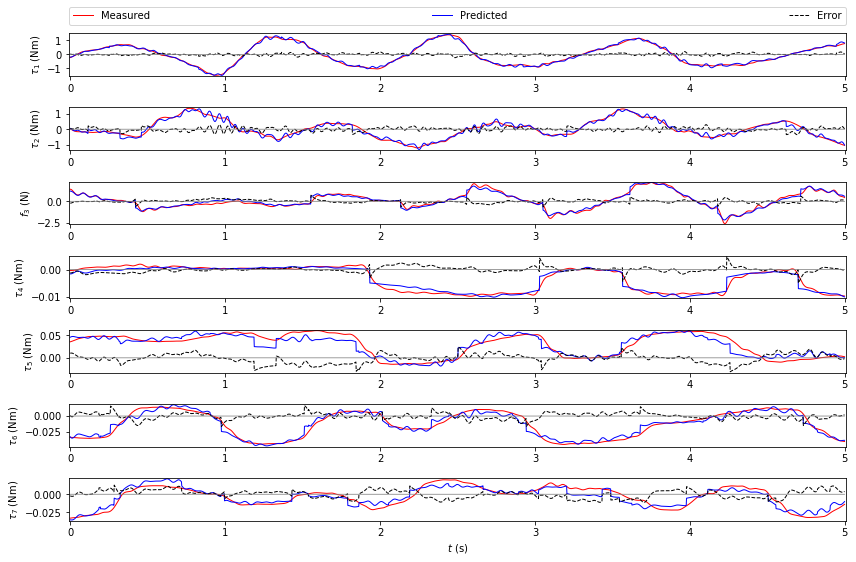

In [70]:
plot_meas_pred_tau(t_cut_train[:plot_data_num], tau_f_train[:plot_data_num, :],
                   tau_p_wls_train[:plot_data_num, :],
                   robot_def.coordinates_joint_type, 
                   robot_model.coordinates)

In [71]:
np.linalg.norm(tau_f_train[:plot_data_num, :] - tau_p_wls_train[:plot_data_num, :], axis=0)\
    / np.linalg.norm(tau_f_train[:plot_data_num, :], axis=0)

array([0.0907546 , 0.20015652, 0.17957444, 0.17679714, 0.26595396,
       0.20132791, 0.38256971])

### Test data set

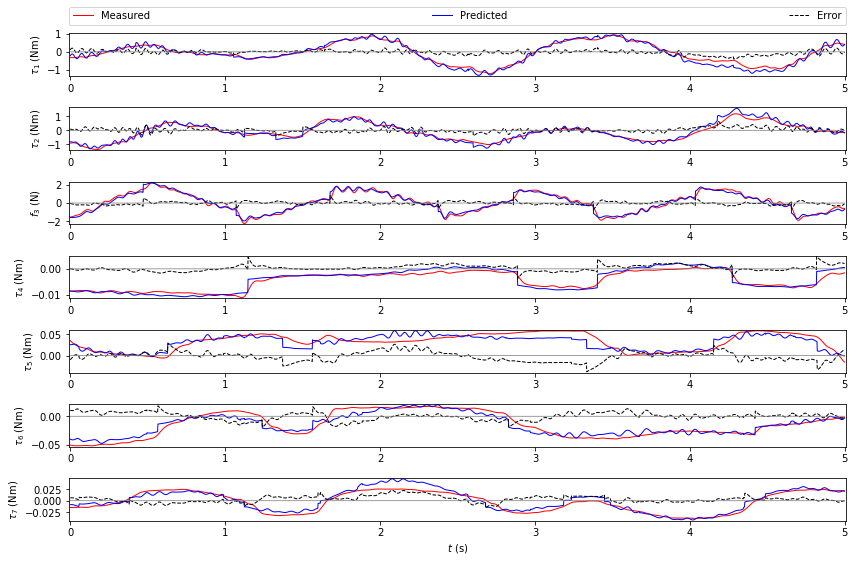

In [72]:
weight = np.max(tau_f_test, axis=0) - np.min(tau_f_test, axis=0)

# repeat the weight to generate a large vecoter for all the data
weights = 1.0/np.tile(weight, W_b_test.shape[0]/weight.shape[0])

W_b_wls_test = np.multiply(W_b_test, np.asmatrix(weights).transpose())
tau_s_wls_test = np.multiply(tau_s_test, weights)

tau_p_wls_test = np.zeros(tau_f_test.shape)
tau_ps_wls_test = W_b_test.dot(xb_wls)
for i in range(dof):
    tau_p_wls_test[:, i] = tau_ps_wls_test[i::dof]

plot_meas_pred_tau(t_cut_test[:plot_data_num], tau_f_test[:plot_data_num, :],
                   tau_p_wls_test[:plot_data_num, :],
                   robot_def.coordinates_joint_type,
                   robot_model.coordinates)

In [73]:
np.linalg.norm(tau_f_test[:plot_data_num, :] - tau_p_wls_test[:plot_data_num, :], axis=0)\
/ np.linalg.norm(tau_f_test[:plot_data_num, :], axis=0)

array([0.21823178, 0.25057784, 0.15832442, 0.20544639, 0.29852731,
       0.26196287, 0.35596636])

## Convex optimization

### Generate regressor matrix for barycentric parameters

In [74]:
from identification import SDPOpt

bary_param_num = len(robot_model.bary_param)
H_func = robot_model.H_func
W_train, tau_s_train = gen_regressor(bary_param_num, H_func,
                                     q_f_train, dq_f_train, ddq_f_train, tau_f_train)

In [75]:
W_w_train = np.multiply(W_train, np.asmatrix(weights).transpose())
tau_w_s_train = np.multiply(tau_s_train, weights)

| min mass | max mass | min $r_x$ | max $r_x$ | min $r_y$ | max $r_y$ | min $r_z$ | max $r_z$ | max $F_c$ | max $F_v$ | max $F_o$ |
|----------|----------|-----------|-----------|-----------|-----------|-----------|-----------|-----------|--------------|-----------|

In [76]:
sdp_constraints = []
spring_constraints = []

if model_name == 'psm_new_dh':
    sdp_constraints = [(0.3, 10, -0.1, 0.1, -0.1, 0.1, -0.1, 0.1, 1, 1, 0.2), #yaw_link
                      (0.3, 10, -0.1, 0.1, -0.2, 0.1, -0.05, 0.05, 1, 1, 0.2),    #Pitch Back
                      (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0), #Intermediate
                      (0.1, 5, 0.1, 0.4, -0.06, 0.02, -0.03, 0.03, 1, 1, 0.2), #Pitch Bottom
                      (0.02, 2, 0.1, 0.4, -0.03, 0.03, -0.03, 0.03, 1, 1, 0.2), #Pitch Top
                      (0.1, 5, 0.0, 0.05, -0.40, 0.05, -0.03, 0.03, 1, 1, 0.2), #Pitch End
                      (0.01, 0.5, -0.05, 0.0, -0.14, 0.0, 0.02, 0.08, 1, 1, 0.2),  #Pitch Front
                      (0.1, 2, -0.02, 0.02, -0.02, 0.02, -0.1, 0.15, 1, 1, 1), #Main Insertion
                      (0.1, 2, -0.05, 0.05, -0.03, 0.03, -0.1, 0.1, 1, 1, 1), #Counterweight
                      (0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1), # Wrist Roll
                      (0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1), # Wrist Pitch
                      (0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1), # Wrist Yaw1
                      (0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1), # Wrist Yaw2
                      (0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1), # M6
                      (0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1), # M7
                      (0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1)] # F67
                       
    spring_constraints = [(0.0001, 1)]
    pass
else:
    raise Exception("No robot name matches " + model_name)

In [77]:


sdp_opt_std = SDPOpt(W_w_train, tau_w_s_train, robot_model,
                     sdp_constraints, spring_constraints)
# sdp_opt_std = SDPOpt(W, tau_s, robot_model, sdp_constraints)
%time sdp_opt_std.solve()

Regressor shape: (102193, 115)
Regressand shape: (102193,)
Creating variables...
Creating optimization objective...
Creating constraints...
Solving problem...
----------------------------------------------------------------------------
	SCS v1.2.6 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012-2016
----------------------------------------------------------------------------
Lin-sys: sparse-indirect, nnz in A = 2350736, CG tol ~ 1/iter^(2.00)
eps = 1.00e-03, alpha = 1.50, max_iters = 2000, normalize = 1, scale = 1.00
Variables n = 116, constraints m = 102494
Cones:	linear vars: 131
	soc vars: 102195, soc blks: 1
	sd vars: 168, sd blks: 8
Setup time: 8.29e-02s
----------------------------------------------------------------------------
 Iter | pri res | dua res | rel gap | pri obj | dua obj | kap/tau | time (s)
----------------------------------------------------------------------------
     0|      inf       inf      -nan      -inf      -inf       inf  3.26e

## Compare measured torque and predicted torque on training set

### Generate predicted torque

In [82]:
tau_p_sdp_train = np.zeros(tau_f_train.shape)
tau_ps_sdp_train = W_train.dot(sdp_opt_std.x_result)
for i in range(dof):
    tau_p_sdp_train[:, i] = tau_ps_sdp_train[i::dof]

In [83]:
np.linalg.norm(tau_f_train[:plot_data_num, :] - tau_p_sdp_train[:plot_data_num, :], axis=0)\
    / np.linalg.norm(tau_f_train[:plot_data_num, :], axis=0)

array([0.08659712, 0.20579402, 0.18161709, 0.17692534, 0.26558982,
       0.20298568, 0.38449653])

### Plot measured torque and predicted torque

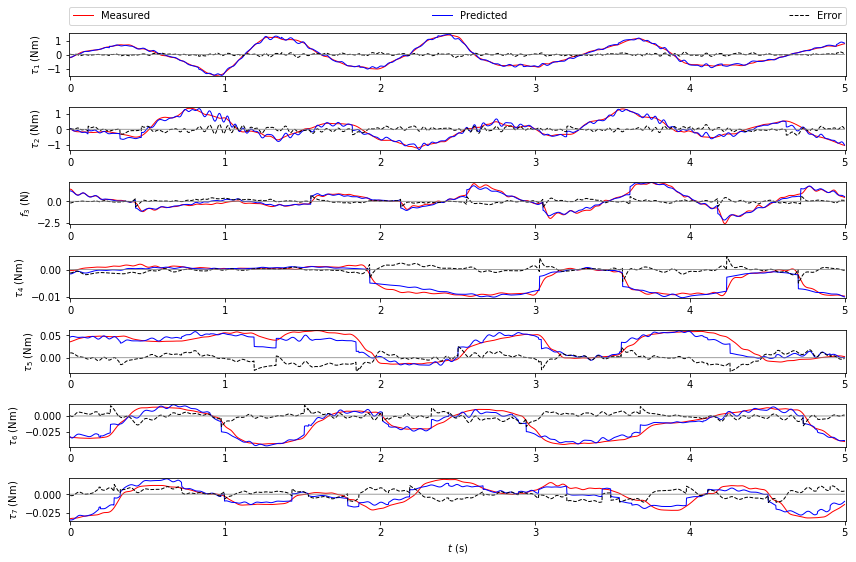

In [84]:
plot_data_num = int(1 / base_freq * trajectory_sampling_rate)
plot_meas_pred_tau(t_cut_train[:plot_data_num] - t_cut_train[0],
                   tau_f_train[:plot_data_num, :],
                   tau_p_sdp_train[:plot_data_num, :],
                   robot_def.coordinates_joint_type,
                   robot_model.coordinates)

## Compare measured torque and predicted torque on test set

In [85]:
bary_param_num = len(robot_model.bary_param)
H_func = robot_model.H_func
W_test, tau_s_test = gen_regressor(bary_param_num, H_func,
                                   q_f_test, dq_f_test, ddq_f_test, tau_f_test)

In [96]:
tau_p_sdp_test = np.zeros(tau_f_test.shape)
tau_ps_sdp_test = W_test.dot(sdp_opt_std.x_result)
for i in range(dof):
    tau_p_sdp_test[:, i] = tau_ps_sdp_test[i::dof]
plot_data_num = int(1 / base_freq * trajectory_sampling_rate)
plot_meas_pred_tau(t_cut_test[:plot_data_num] - t_cut_test[0],
                   tau_f_test[:plot_data_num, :],
                   tau_p_sdp_test[:plot_data_num, :],
                   robot_def.coordinates_joint_type,
                   robot_model.coordinates)

In [87]:
np.linalg.norm(tau_f_test[:plot_data_num, :] - tau_p_sdp_test[:plot_data_num, :], axis=0)\
/ np.linalg.norm(tau_f_test[:plot_data_num, :], axis=0)

array([0.16453677, 0.24382768, 0.15751331, 0.20588095, 0.29879068,
       0.26129296, 0.35815597])

In [88]:
from identification import barycentric2standard_params

In [89]:
x_std = barycentric2standard_params(sdp_opt_std.x_result, robot_model)

In [90]:
sympy.Matrix.hstack(sympy.Matrix(robot_model.std_param), sympy.Matrix(x_std))

⎡I1xx    0.290559039718859  ⎤
⎢                           ⎥
⎢I1xy   -0.0204781877447245 ⎥
⎢                           ⎥
⎢I1xz  2.02841290127503e-19 ⎥
⎢                           ⎥
⎢I1yy    0.462573062686208  ⎥
⎢                           ⎥
⎢I1yz  1.66160245432329e-17 ⎥
⎢                           ⎥
⎢I1zz  0.000252140883720293 ⎥
⎢                           ⎥
⎢r1x    0.0482036228684517  ⎥
⎢                           ⎥
⎢r1y    -0.0703800044637699 ⎥
⎢                           ⎥
⎢r1z   -5.29095265265752e-19⎥
⎢                           ⎥
⎢ m₁     2.25833457191799   ⎥
⎢                           ⎥
⎢Fc₁    0.0556683040846012  ⎥
⎢                           ⎥
⎢Fv₁     0.106785591665255  ⎥
⎢                           ⎥
⎢Fo₁    -0.200062541743711  ⎥
⎢                           ⎥
⎢I2xx  0.000343889808986614 ⎥
⎢                           ⎥
⎢I2xy   0.00012892518376155 ⎥
⎢                           ⎥
⎢I2xz  -0.000798414555285075⎥
⎢                           ⎥
⎢I2yy  0.000460481083087664 ⎥
⎢         